# Convolution & understanding its inner workings
Creating the common methods and classes which will be used and reused across the whole notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Checking the GPU available on Goolge colab.<br>
UnLuckily, the Google's priority GPU allocation frequently left me with no GPU to train. So had to buy google colab pro and then got a beast of GPU.

Please ignore my above rambling.

In [ ]:
!nvidia-smi

Sun Oct  3 23:39:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importing the libraries and dependencies
The following cell block imports all the libraries, functions, methods that are being used inn this jupyter notebook.<br>
The Deep Learning/Machine Learning Libarary being used here is the high level keras API of tensorflow 2.X.<Br>
And the plotting is done with matplotlib and seaborn plotting packages.

Along with this all the constants that will be common throughout the file are defined and declared here.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import CSVLogger
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random, cv2
%matplotlib inline

EPOCHS = 200
BATCH_SIZE = 128
CLASSES = 10
IMG_DIM = (28, 28)
SHUFFLE = False
MODEL_INP_SIZE = (28, 28)
NUM_LAYERS = 5
ACCURACY_THRESHOLD = 0.98
LEARNING_RATE = 0.001
SEED = 1

### Loading Data
The following block of code loads MNIST data in two formats.
- First is through the dataset module from keras which loads data in numpy arrays.
- Second is the TFDS - Tensorflow dataset module which loads data in the format of tenorflow_dataset whic makes it fast o process and load data onto and away from the memory(GPU/CPU)

I experimented with both the above techniques but the second one was very fast and thats what i am sticking with.
As it loads the next batch of data onto GPU memory while the current batch is being operated on - this is done with the prefetching functionality of the tensirflow_dataset module.

In [ ]:
# Dataset importing from the dataset module of tensorflow keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Below code from TFDS documentation
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label
    
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

11501568/11490434 [==============================] - 0s 0us/step


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


As it can be seen that there are around 60,000 training images in the MNIST which are shaped in a 3D array with each shape of image being 28*28.

And there are 10,000 testing images which will being used as validation data while training the model.

In [ ]:
print(f"The size of the feature set of training set is {x_train.shape}")
print(f"The size of the target set of training set is {y_train.shape}")
print(f"The size of the feature set of test set is {x_test.shape}")
print(f"The size of the target set of test set is {y_test.shape}")

The size of the feature set of training set is (60000, 28, 28)
The size of the target set of training set is (60000,)
The size of the feature set of test set is (10000, 28, 28)
The size of the target set of test set is (10000,)


### Custom Callback
This class of custom callback stops the training of the model as soon as the validation accuracy reached 98%.

Note:- Originally i was using checkpoints to save the best model at each epoch when the models wre running slow but i have commented/removed this peace of code since i started using prefetching.

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # keys = list(logs.keys())
        # print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% validation accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

# checkpoint = keras.callbacks.ModelCheckpoint('', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

### Model architecture Declaration methods
There are three helper methods :-
- seed_everthing - sets the seed for numpy, tensorflow and random modules so that when we try and replicate a result we can do so if the seeds are same.
- clear_tf - clears the backend of the tensorflow module.
- Model - this method defines a common method which will used commonly accross all the question to define a Deep Learning model.

In [ ]:
def seed_everything(n):
    np.random.seed(n)
    tf.compat.v1.random.set_random_seed(n)
    random.seed(n)

def clear_tf():
    tf.keras.backend.clear_session()

def Model(inp_size = MODEL_INP_SIZE,
          layers = NUM_LAYERS, 
          layers_nodes = [1024]*5, 
          dropout_include = False, 
          dropout_ratio = [0.2]*5,
          activation_fn = keras.layers.LeakyReLU(),
          initializer = 'glorot_uniform',    # Default value
          loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(),
          optimizer = keras.optimizers.Adam(), 
          include_normalization = True):
    
    assert layers == len(layers_nodes), "Layer size and number of nodes for each layer are not equal"
    assert layers == len(dropout_ratio), "Dropout array size and number of layers do not match"

    inp = keras.layers.Input(shape = inp_size)
    layer_x = keras.layers.Flatten()(inp)
    layer_x = keras.layers.Dense(layers_nodes[0], 
                                 activation = activation_fn,
                                 kernel_initializer = initializer,
                                 name = 'Dense_Layer_1')(layer_x)
    if include_normalization:
        layer_x = keras.layers.BatchNormalization()(layer_x)

    # Drop out layer for part 3
    if dropout_include:
        layer_x = keras.layers.Dropout(dropout_ratio[0])(layer_x)

    for layer_num in range(1, layers):
        layer_x = keras.layers.Dense(layers_nodes[layer_num], 
                                     activation = activation_fn,
                                     kernel_initializer = initializer,
                                     name = 'Dense_Layer_'+str(layer_num+1))(layer_x)
        if include_normalization:
            layer_x = keras.layers.BatchNormalization()(layer_x)
        if dropout_include:
            layer_x = keras.layers.Dropout(dropout_ratio[layer_num])(layer_x)
    
    out = keras.layers.Dense(10, activation = "softmax", name = "Output")(layer_x)

    model = keras.models.Model(inputs = inp, outputs = out)
    model.compile(loss = loss_fn, 
                  optimizer = optimizer, 
                  metrics = ['accuracy'])
    
    return model

seed_everything(SEED)
Model(inp_size=(28, 28)).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 1024)              803840    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
Dense_Layer_2 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 1024)              104960

In [ ]:
clear_tf()

In [ ]:
# Below code created with the help from following website: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(keras.utils.Sequence):
    def __init__(self, dataset, labels, 
                 batch_size = BATCH_SIZE, 
                 dim = IMG_DIM, 
                 n_classes = CLASSES, 
                 shuffle = SHUFFLE):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.dataset = dataset
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.list_IDs = np.arange(self.dataset.shape[0])
        self.indexes = np.arange(len(self.list_IDs))
        # self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(self.dataset.shape[0] / self.batch_size))

    def __getitem__(self, index):

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # X[i,] = np.squeeze(cv2.resize(self.dataset[ID], (self.dim[0]*self.dim[1],1)))
            X[i,] = self.dataset[ID]
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

train_generator = DataGenerator(x_train, 
                                y_train)
val_generator = DataGenerator(x_test, 
                              y_test)

# A Detailed View to MNIST Classification

### Training the models
Training with the following architecture:-
- Model Parameters
          inp_size = (28,28), # Image Size
          layers = 5, # Number of hidden layers in Model
          layers_nodes = [1024]*5, # Nodes in each hidden layer
          dropout_include = False, # Flag to include dropout
          dropout_ratio = [0.2]*5, # If flag is enbled then how much dropout to include for each layer
          activation_fn = keras.layers.LeakyReLU(), # Activation function of each layer except last/output layer
          initializer = 'glorot_uniform',    # Default value - for kernel_initializer
          loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(),
          optimizer = keras.optimizers.Adam(), 
          include_normalization = True


In [ ]:
model = Model(inp_size=(28, 28))
model.fit(ds_train,
            validation_data=ds_test,
            # use_multiprocessing=True, 
            epochs=EPOCHS,
            callbacks = [CustomCallback()])

Epoch 1/200
469/469 [==============================] - 11s 7ms/step - loss: 0.2528 - accuracy: 0.9292 - val_loss: 0.1533 - val_accuracy: 0.9554
Epoch 2/200
469/469 [==============================] - 2s 5ms/step - loss: 0.1240 - accuracy: 0.9610 - val_loss: 0.1749 - val_accuracy: 0.9545
Epoch 3/200
469/469 [==============================] - 2s 5ms/step - loss: 0.1033 - accuracy: 0.9677 - val_loss: 0.1132 - val_accuracy: 0.9673
Epoch 4/200
469/469 [==============================] - 2s 5ms/step - loss: 0.0847 - accuracy: 0.9729 - val_loss: 0.1090 - val_accuracy: 0.9693
Epoch 5/200
469/469 [==============================] - 2s 5ms/step - loss: 0.0745 - accuracy: 0.9772 - val_loss: 0.1250 - val_accuracy: 0.9674
Epoch 6/200
469/469 [==============================] - 2s 5ms/step - loss: 0.0640 - accuracy: 0.9791 - val_loss: 0.1018 - val_accuracy: 0.9721
Epoch 7/200
469/469 [==============================] - 2s 5ms/step - loss: 0.0633 - accuracy: 0.9793 - val_loss: 0.1567 - val_accuracy: 0.959

Plotting the accuracies and losses of the model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


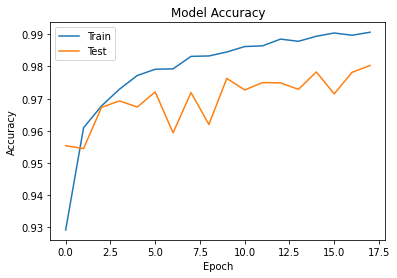

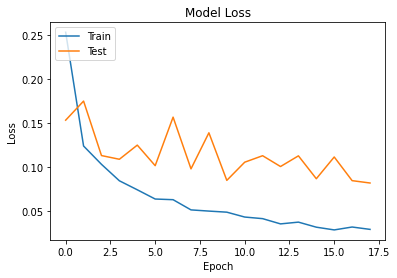

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Model Summary

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 1024)              803840    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
Dense_Layer_2 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 1024)              104960

### TSNE, PCA & Layer outputs:
Steps followed:-
- Take 1000 images - From 8000 to 9000
- created a function for layer outputs, TSNE and PCA
- looped through the layers in the moel and created a intermediate model to get the output from each layer and plotted that


In [ ]:
test_1000_images = x_test[8000:9000]
images = x_test[8000:9000]
test_1000_images_label = y_test[8000:9000]
img_labels = y_test[8000:9000]

The following block contains a function which takes the name of a layer and creates an intermediate model which plots the image on a 10x10 grid.
Outputs the prediction from the resp. hidden layer where the 1000 X 1024 was converted into 1000 X 10 with randomly selected 10 columns and using argmax function from numpy module to get the column with the highest rating and use that as a label which is being used a row index to plot the image to check how correct is a layer predicting the image.

In [ ]:
def plot_images(layer_name, mod, data, labels, final_layer = False):
    layer_output = mod.get_layer(layer_name).output

    intermediate_model = tf.keras.models.Model(inputs = mod.input,
                                               outputs = layer_output)
    
    intermediate_prediction = intermediate_model.predict(data)
    if final_layer:
        out_preds = np.argmax(intermediate_prediction, axis=1)
    else:
        arr_idx = random.sample(range(1024), 10)
        arr_idx.sort()
        print(f"Coluns selected are : ", arr_idx)
        out_preds = np.argmax(intermediate_prediction[:,arr_idx], axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(10):
        X = np.where(out_preds == i)[:10]
        for j in range(10):
            ax=plt.subplot2grid((10, 10), (i, j))
            try:
                ax.imshow(data[X[0][j]], cmap='gray')#.reshape((28,28)))
            except:
                pass
            plt.axis('off')
    plt.show()

Plotting the output of the model by passing 1000 images as the input

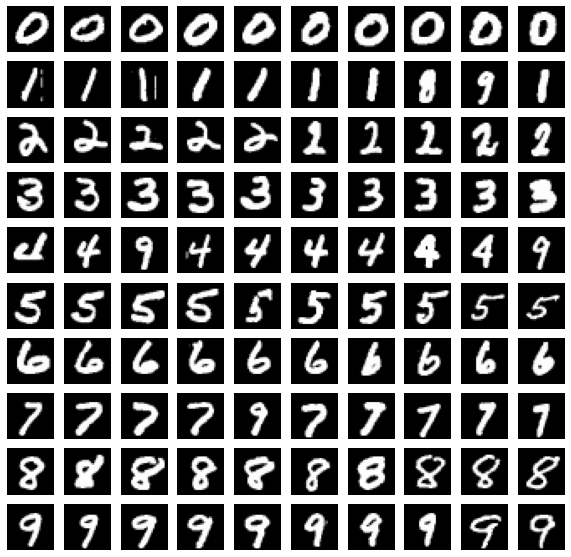

In [ ]:
plot_images("Output", model, test_1000_images, test_1000_images_label, final_layer = True)

### Inner working of CNN
Plotting the output of all the hidden layers in the model by passing 1000 images as the input and getting 1024 dimensional vector as output.
```
Explain your observation compared with the results from the last layer.
```
The difference in output between the last layer (softmax layer) and the second to the last layer i.e. 5th Dense layer is that all the results and caculations are being fed into the 10 units of the last layer while we are selecting some random column from the output of 1024 vectors are using that as 10 dimensional output to predict the label.<br>
This could result in very varying outputs based on the columns that are beong selected as labels predictors because for some images some columns are not being hit/popular/turned on.

While in the last layer we are chosing one label (predicted) definitely from the 10 dimensional output of the softmax layer but in other layer some columns are not generating a output for a model.

From the 10x10 grid it can be seen that based on the columns selected the classifier is able to identify some of the images correctly like best case are the images with true labels as '0'. while for some labels like '1' there are no outputs because they are not popular as stated in the assignment. In laymans term the neurons associated to 1 were not taken as input to the columns selected on random. They just didnt go off.<br>
Other digits that were identified correctly to some degree are 9, 8 and 6 - in the decresing order, numbers as seen in the 10x10 grid.

The ideal situation for the second-to-the-last layer can be that the layer weights transform into such a way that it is clearly able to identify a image with a huge margin as compared to other labels.<br>
Also in an ideal situation this layer won't even be needed as according to the Universal Approxiamtion theorem one hidden layer which is sufficiently deep enough will be able to adapt mostly all the scenario.

Printing images for layer :  Dense_Layer_1
Coluns selected are :  [129, 192, 241, 275, 429, 522, 777, 920, 967, 1014]


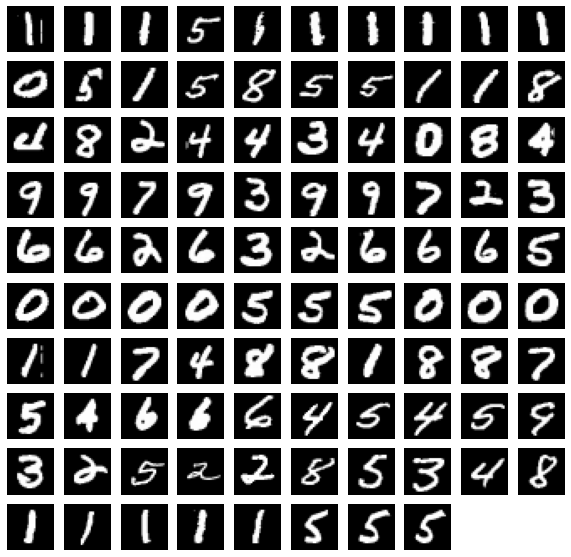

Printing images for layer :  Dense_Layer_2
Coluns selected are :  [4, 58, 209, 468, 545, 650, 798, 886, 912, 999]


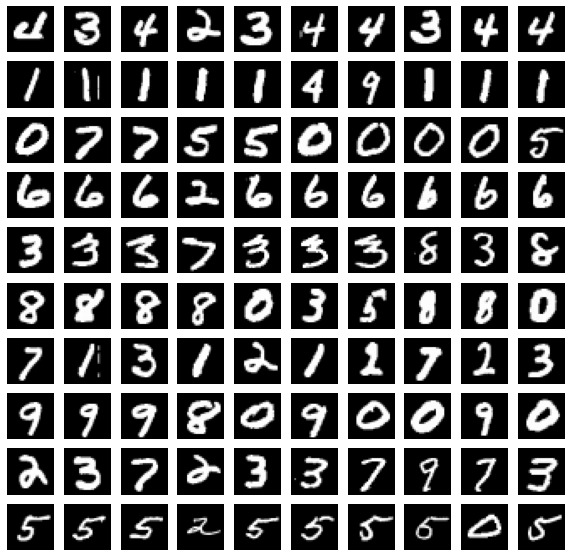

Printing images for layer :  Dense_Layer_3
Coluns selected are :  [18, 45, 52, 59, 62, 443, 454, 780, 864, 896]


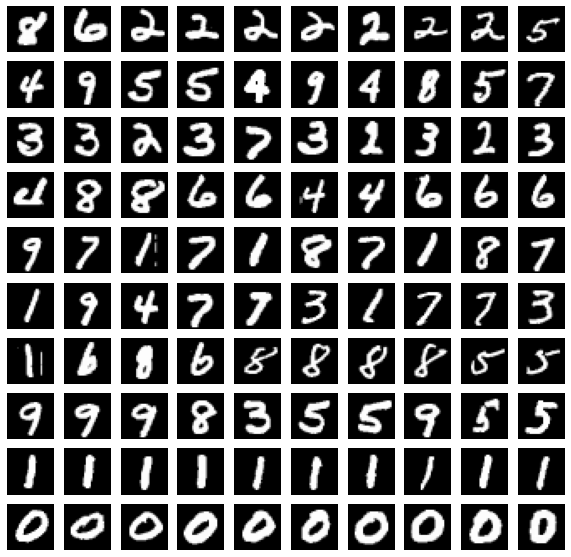

Printing images for layer :  Dense_Layer_4
Coluns selected are :  [44, 204, 448, 472, 477, 593, 707, 852, 941, 1015]


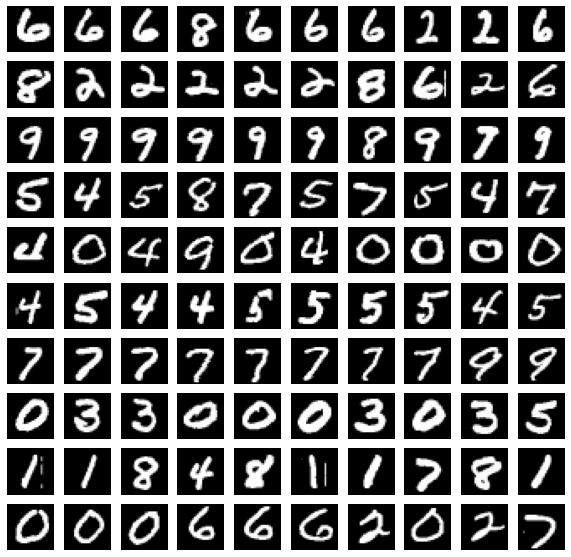

Printing images for layer :  Dense_Layer_5
Coluns selected are :  [247, 380, 388, 581, 607, 621, 681, 805, 864, 1022]


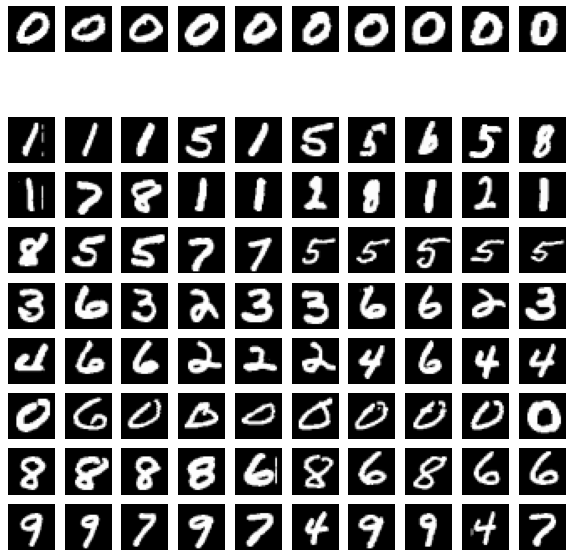

In [ ]:
idx = 0
for layer in model.layers:
    name = layer.name
    if 'Dense' in name and idx < NUM_LAYERS:
        print("Printing images for layer : ", name)
        plot_images(name, model, test_1000_images, test_1000_images_label)
        idx+=1

Hidden layer 1 output when 1000 images passed as input and best 100 images are displayed on a 10x10 grid

Coluns selected are :  [182, 256, 283, 352, 478, 530, 567, 726, 814, 821]


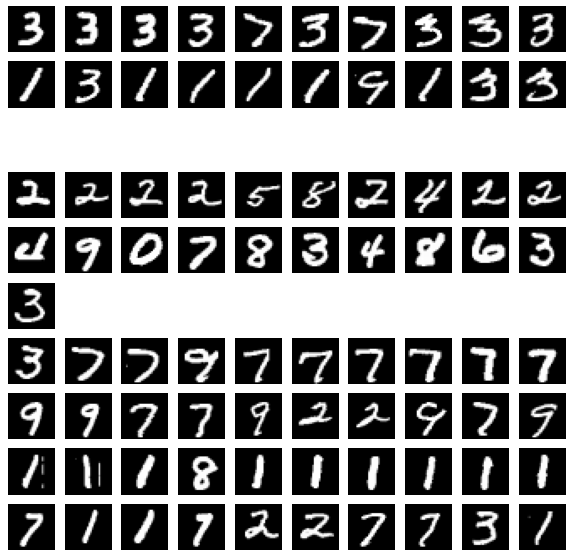

In [ ]:
plot_images("Dense_Layer_1", model, test_1000_images, test_1000_images_label)

The following block outputs the prediction from the first hidden layer where the 1000 X 1024 was converted into 1000 X 10 with randomly selected 10 columns and using argmax function from numpy module to get the column with the highest rating and use that as a label which is being compared with the true labels by plotting the predicted label image in the respective column.

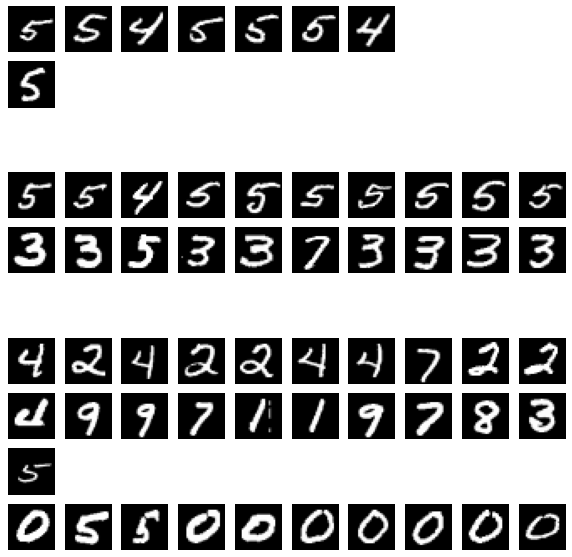

In [ ]:
plot_images("Dense_Layer_1", model, test_1000_images, test_1000_images_label)

In [ ]:
test_1000_images.resize((1000, 784))
test_1000_images.shape

(1000, 784)

The PCA for 1000 raw images which doesnt show much but a mess of points scattered around except the number '1' which seems to be seperate fro the group and is easily identifyable

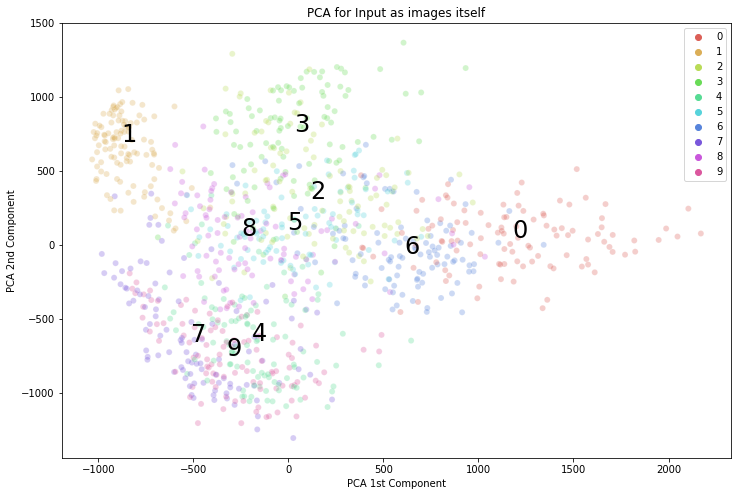

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_1000_images)

plt.figure(figsize=(12,8))
sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1],
    hue = test_1000_images_label,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
plt.title("PCA for Input as images itself")
plt.xlabel("PCA 1st Component")
plt.ylabel("PCA 2nd Component")

for i in range(10):
    xtext, ytext = np.median(pca_result[test_1000_images_label == i, :], axis=0)
    plt.text(xtext, ytext, str(i), fontsize=24)

plt.show()

The TSNE for 1000 raw images is much clear than its PCA counterpart which showsthat each image can be seperated into its own group and easily identifyable with naked eye.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.050s...
[t-SNE] Computed neighbors for 1000 samples in 1.550s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 601.110327
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.262688
[t-SNE] KL divergence after 500 iterations: 0.664023


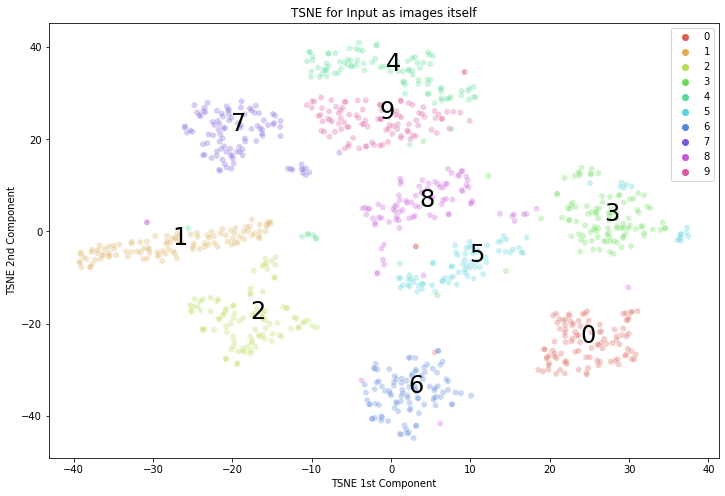

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results = tsne.fit_transform(test_1000_images)

plt.figure(figsize=(12,8))
sns.scatterplot(
    x = tsne_results[:,0], 
    y = tsne_results[:,1],
    hue=test_1000_images_label,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
plt.title("TSNE for Input as images itself")
plt.xlabel("TSNE 1st Component")
plt.ylabel("TSNE 2nd Component")

for i in range(10):
    xtext, ytext = np.median(tsne_results[test_1000_images_label == i, :], axis=0)
    plt.text(xtext, ytext, str(i), fontsize=24)

plt.show()

The following few block of codes plots the output of each hidden layer when transformed from a higher dimension - 1024 - to 2 dimensions which makes it easier to visualize on a 2D graph, using PCA and T-SNE.<br>
Some points identified from the graphs:-
- TSNE becomes more clear as we start going down the line
- The TSNE plot for 1st hidden layer helps prove that if the layer sufficiently large enough then it is more than enough - Universal Approximation theorem.
- PCA is not clear for the data set transfromation

In [ ]:
def visualize_layer_PCA(layer_name, data, labels, mod):#, ax):
    layer_output = mod.get_layer(layer_name).output

    intermediate_model = tf.keras.models.Model(inputs = mod.input,
                                               outputs = layer_output)
    
    intermediate_prediction = intermediate_model.predict(data)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(intermediate_prediction)

    plt.figure(figsize=(10,6))
    sns.scatterplot(
        x = pca_result[:,0], 
        y = pca_result[:,1],
        hue=labels,
        palette = sns.color_palette("hls", 10),
        legend = "full",
        alpha = 0.3)#, ax = ax)
    plt.title(f"PCA for layer {layer_name}")
    plt.xlabel("PCA 1st Component")
    plt.ylabel("PCA 2nd Component")
    for i in range(10):
        xtext, ytext = np.median(pca_result[labels == i, :], axis=0)
        plt.text(xtext, ytext, str(i), fontsize=24)
    plt.show()

In [ ]:
def visualize_layer_TSNE(layer_name, data, labels, mod,):# ax):
    layer_output = mod.get_layer(layer_name).output

    intermediate_model = tf.keras.models.Model(inputs = mod.input,
                                               outputs = layer_output)
    
    intermediate_prediction = intermediate_model.predict(data)

    tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=400)
    tsne_results = tsne.fit_transform(intermediate_prediction)

    plt.figure(figsize=(10,6))
    sns.scatterplot(
        x = tsne_results[:,0], 
        y = tsne_results[:,1],
        hue=labels,
        palette=sns.color_palette("hls", 10),
        legend="full",
        alpha=0.3,)
        # ax = ax)
    plt.title(f"TSNE for layer {layer_name}")
    plt.xlabel("TSNE 1st Component")
    plt.ylabel("TSNE 2nd Component")
    for i in range(10):
        xtext, ytext = np.median(tsne_results[labels == i, :], axis=0)
        plt.text(xtext, ytext, str(i), fontsize=24)
    plt.show()

Somehow the layers are very good


PCA & T-SNE for layer :  Dense_Layer_1


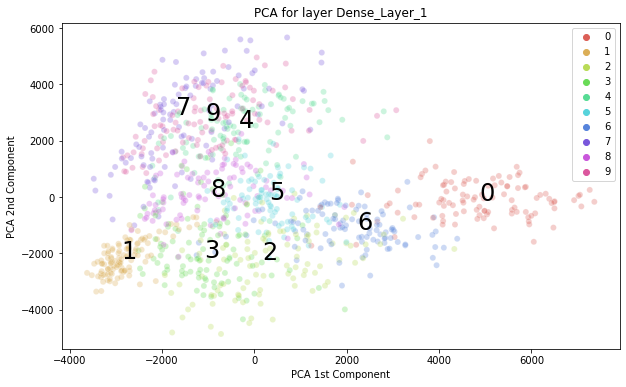

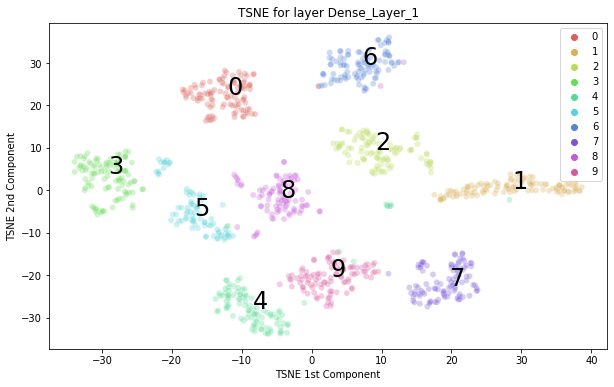

PCA & T-SNE for layer :  Dense_Layer_2


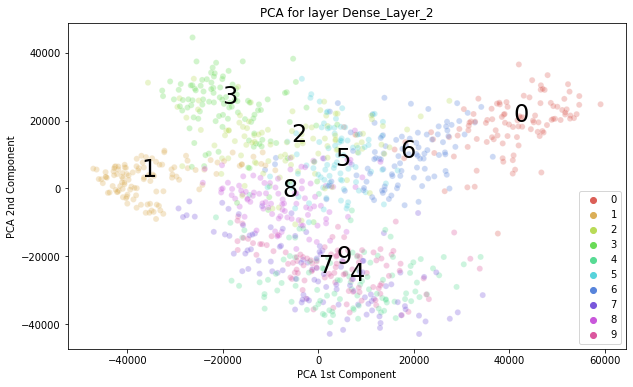

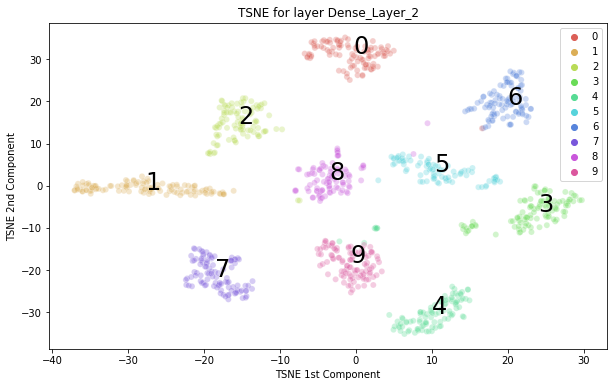

PCA & T-SNE for layer :  Dense_Layer_3


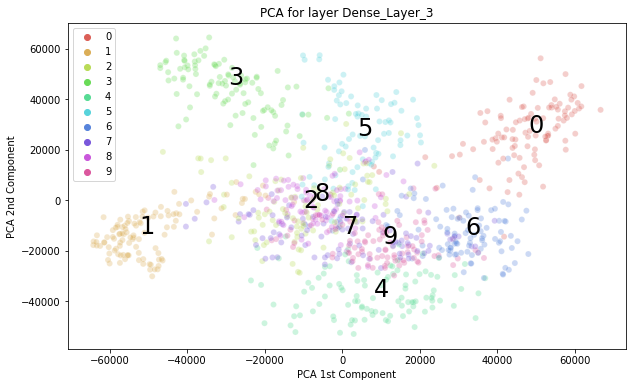

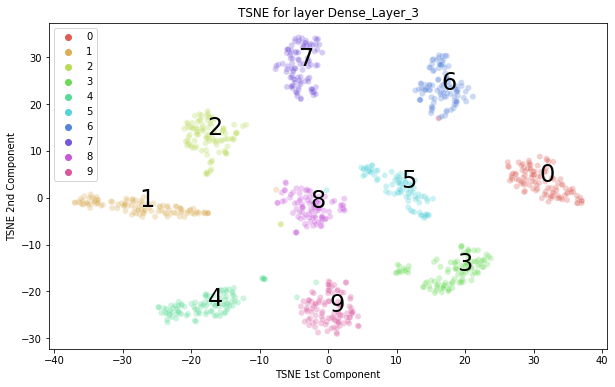

PCA & T-SNE for layer :  Dense_Layer_4


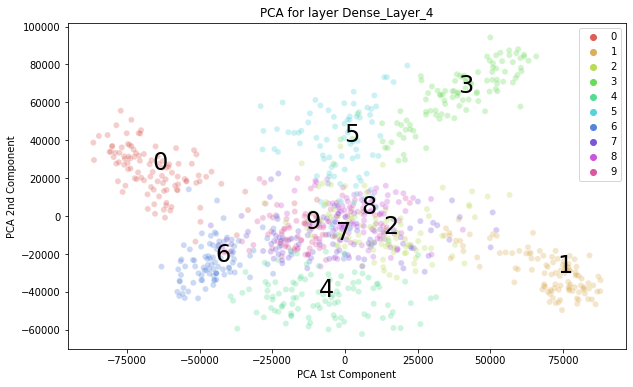

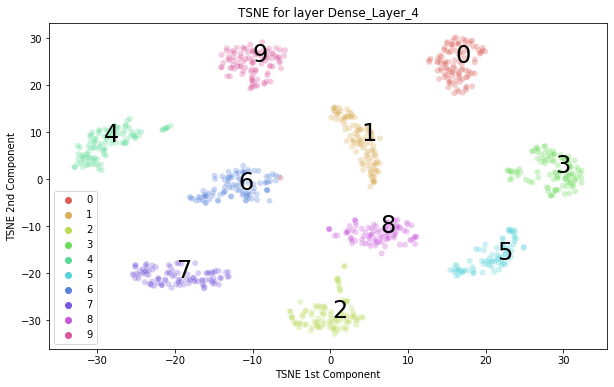

PCA & T-SNE for layer :  Dense_Layer_5


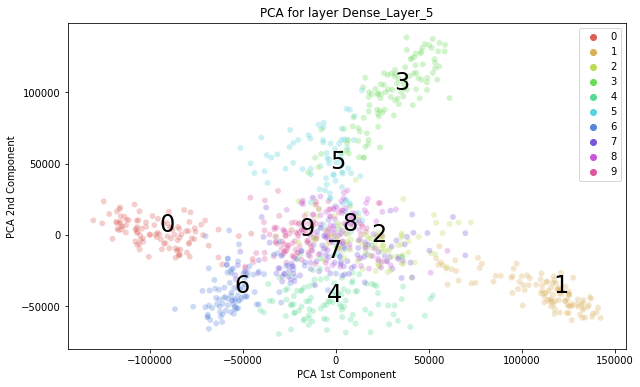

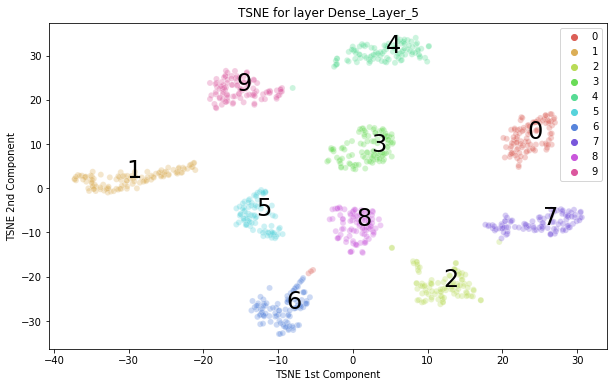

In [ ]:
for layer in model.layers:
    name = layer.name
    if 'Dense' in name: 
        print("PCA & T-SNE for layer : ", name)
        visualize_layer_PCA(name, images, img_labels, model)
        visualize_layer_TSNE(name, images, img_labels, model)

# Adult Optimization

Goal for this question was to learn the effect of different initialization has on the models with the same architecture

In [ ]:
model_sigmoid_random_SGD = Model(layers_nodes = [512]*5, 
                                activation_fn = 'sigmoid',
                                initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
                                optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE),
                                include_normalization = False)

model_sigmoid_xavier_SGD = Model(layers_nodes = [512]*5, 
                                activation_fn = 'sigmoid',
                                initializer = 'glorot_normal',
                                optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE),
                                include_normalization = False)

model_relu_random_SGD = Model(layers_nodes = [512]*5, 
                                activation_fn = 'relu',
                                initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
                                optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE),
                                include_normalization = False)

model_relu_xavier_SGD = Model(layers_nodes = [512]*5, 
                                activation_fn = 'relu',
                                initializer = 'glorot_normal',
                                optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE),
                                include_normalization = False)

model_relu_he_SGD = Model(layers_nodes = [512]*5, 
                                activation_fn = 'relu',
                                initializer = 'he_normal',
                                optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE),
                                include_normalization = False)



model_sigmoid_random_Adam = Model(layers_nodes = [512]*5, 
                                activation_fn = 'sigmoid',
                                initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
                                optimizer = keras.optimizers.Adam(),
                                include_normalization = False)

model_sigmoid_xavier_Adam = Model(layers_nodes = [512]*5, 
                                activation_fn = 'sigmoid',
                                initializer = 'glorot_normal',
                                optimizer = keras.optimizers.Adam(),
                                include_normalization = False)

model_relu_random_Adam = Model(layers_nodes = [512]*5, 
                                activation_fn = 'relu',
                                initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
                                optimizer = keras.optimizers.Adam(),
                                include_normalization = False)

model_relu_xavier_Adam = Model(layers_nodes = [512]*5, 
                                activation_fn = 'relu',
                                initializer = 'glorot_normal',
                                optimizer = keras.optimizers.Adam(),
                                include_normalization = False)

model_relu_he_Adam = Model(layers_nodes = [512]*5, 
                                activation_fn = 'relu',
                                initializer = 'he_normal',
                                optimizer = keras.optimizers.Adam(),
                                include_normalization = False)

sgd_models = [(model_sigmoid_random_SGD, "Sigmoid Random - SGD"),
            (model_sigmoid_xavier_SGD, "Sigmoid Xavier - SGD"),
            (model_relu_random_SGD, "relu Random - SGD"),
            (model_relu_xavier_SGD, "relu Xavier - SGD"),
            (model_relu_he_SGD, "relu HE - SGD")]

adam_models = [(model_sigmoid_random_Adam, "Sigmoid Random - Adam"),
            (model_sigmoid_xavier_Adam, "Sigmoid Xavier - Adam"),
            (model_relu_random_Adam, "Relu Random - Adam"),
            (model_relu_xavier_Adam, "Relu Xavier - Adam"),
            (model_relu_he_Adam, "Relu HE - Adam")]

### Trining for SGD models

In [ ]:
model_sigmoid_random_SGD.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 512)               401920    
_________________________________________________________________
Dense_Layer_2 (Dense)        (None, 512)               262656    
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 512)               262656    
_________________________________________________________________
Dense_Layer_4 (Dense)        (None, 512)               262656    
_________________________________________________________________
Dense_Layer_5 (Dense)        (None, 512)               2626

### Models trained
- Sigmoid with random initialization Random with SGD
- Sigmoid with random initialization Xavier with SGD
- ReLU with random initialization Random with SGD
- ReLU with random initialization Xavier with SGD
- ReLU with random initialization HE with SGD

In [ ]:
for model_, name in sgd_models:
    print(name)
    model_.fit(ds_train, 
               validation_data = ds_test,
               epochs = EPOCHS,
               verbose = 1)

Sigmoid Random - SGD
Epoch 1/200
469/469 [==============================] - 2s 3ms/step - loss: 2.3052 - accuracy: 0.1077 - val_loss: 2.3095 - val_accuracy: 0.1028
Epoch 2/200
469/469 [==============================] - 1s 3ms/step - loss: 2.3041 - accuracy: 0.1063 - val_loss: 2.3018 - val_accuracy: 0.1135
Epoch 3/200
469/469 [==============================] - 1s 3ms/step - loss: 2.3039 - accuracy: 0.1070 - val_loss: 2.3043 - val_accuracy: 0.1028
Epoch 4/200
469/469 [==============================] - 1s 3ms/step - loss: 2.3038 - accuracy: 0.1082 - val_loss: 2.3036 - val_accuracy: 0.1028
Epoch 5/200
469/469 [==============================] - 1s 3ms/step - loss: 2.3038 - accuracy: 0.1069 - val_loss: 2.3035 - val_accuracy: 0.1135
Epoch 6/200
469/469 [==============================] - 1s 3ms/step - loss: 2.3039 - accuracy: 0.1069 - val_loss: 2.3030 - val_accuracy: 0.1032
Epoch 7/200
469/469 [==============================] - 1s 3ms/step - loss: 2.3039 - accuracy: 0.1074 - val_loss: 2.3036 -

### Plotting for SGD models
Plotted test accuracy for SGD models and divided into 3 graphs:
- First shows the whole history
- Second shows the whole history from 0 to 50 epoch
- Third shows the history from 50 to 200 epoch

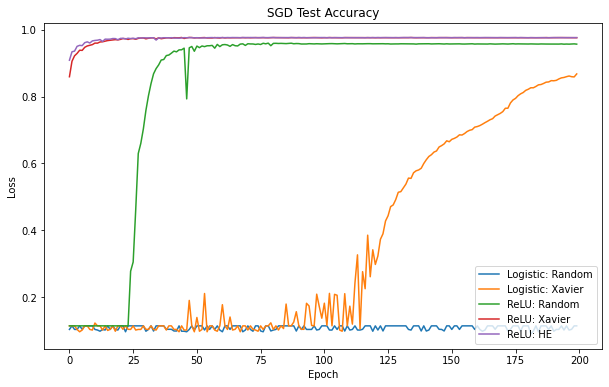

In [ ]:
fig = plt.figure(figsize = (10, 6))
for model_,_ in sgd_models:
    plt.plot(model_.history.history['val_accuracy'])
    
plt.legend(['Logistic: Random', 'Logistic: Xavier', 'ReLU: Random', 'ReLU: Xavier', 'ReLU: HE'], loc='lower right')
plt.title('SGD Test Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

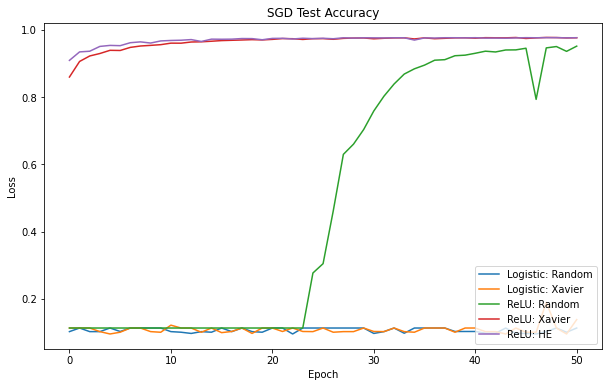

In [ ]:
fig = plt.figure(figsize = (10, 6))
for model_,_ in sgd_models:
    plt.plot(range(51), model_.history.history['val_accuracy'][:51])
    
plt.legend(['Logistic: Random', 'Logistic: Xavier', 'ReLU: Random', 'ReLU: Xavier', 'ReLU: HE'], loc='lower right')
plt.title('SGD Test Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

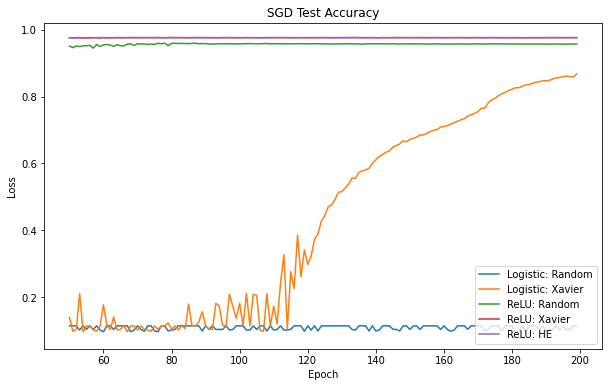

In [ ]:
fig = plt.figure(figsize = (10, 6))
for model_,_ in sgd_models:
    plt.plot(range(50, 200), model_.history.history['val_accuracy'][50:])
    
plt.legend(['Logistic: Random', 'Logistic: Xavier', 'ReLU: Random', 'ReLU: Xavier', 'ReLU: HE'], loc='lower right')
plt.title('SGD Test Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Training for Adam models

In [ ]:
model_relu_xavier_Adam.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 512)               401920    
_________________________________________________________________
Dense_Layer_2 (Dense)        (None, 512)               262656    
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 512)               262656    
_________________________________________________________________
Dense_Layer_4 (Dense)        (None, 512)               262656    
_________________________________________________________________
Dense_Layer_5 (Dense)        (None, 512)               2626

### Models Trained
- Sigmoid with initialization as Random with Adam
- Sigmoid with initialization as Xavier with Adam
- Relu with initialization as Random with Adam
- Relu with initialization as Xavier with Adam
- Relu with initialization as HE with Adam

In [ ]:
for model_,name in adam_models:
    print(name)
    model_.fit(ds_train, 
               validation_data = ds_test,
               epochs = EPOCHS,
               verbose = 1)

Sigmoid Random - Adam
Epoch 1/200
469/469 [==============================] - 4s 6ms/step - loss: 1.5731 - accuracy: 0.3685 - val_loss: 1.3175 - val_accuracy: 0.4791
Epoch 2/200
469/469 [==============================] - 3s 6ms/step - loss: 0.9890 - accuracy: 0.6461 - val_loss: 0.7217 - val_accuracy: 0.7551
Epoch 3/200
469/469 [==============================] - 3s 6ms/step - loss: 0.5996 - accuracy: 0.8104 - val_loss: 0.5001 - val_accuracy: 0.8480
Epoch 4/200
469/469 [==============================] - 3s 6ms/step - loss: 0.4376 - accuracy: 0.8663 - val_loss: 0.4447 - val_accuracy: 0.8656
Epoch 5/200
469/469 [==============================] - 3s 6ms/step - loss: 0.3821 - accuracy: 0.8826 - val_loss: 0.3441 - val_accuracy: 0.8959
Epoch 6/200
469/469 [==============================] - 3s 6ms/step - loss: 0.3344 - accuracy: 0.8994 - val_loss: 0.3470 - val_accuracy: 0.8949
Epoch 7/200
469/469 [==============================] - 3s 6ms/step - loss: 0.3067 - accuracy: 0.9067 - val_loss: 0.2868 

### Plotting for Adam models
Plotted test accuracy for Adam models and divided into 3 graphs:
- First shows the whole history
- Second shows the whole history from 0 to 20 epoch
- Third shows the history from 20 to 200 epoch

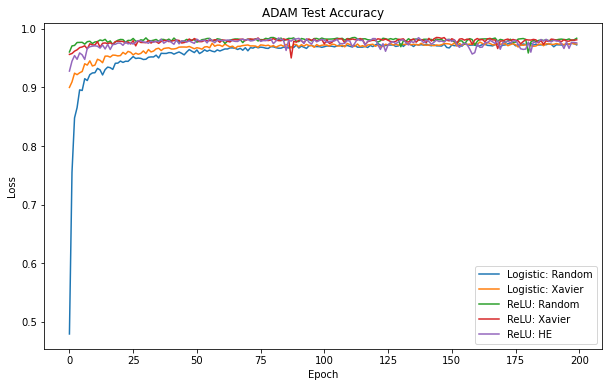

In [ ]:
fig = plt.figure(figsize = (10, 6))
for model_, _ in adam_models:
    plt.plot(model_.history.history['val_accuracy'])
    
plt.legend(['Logistic: Random', 'Logistic: Xavier', 'ReLU: Random', 'ReLU: Xavier', 'ReLU: HE'], loc='lower right')
plt.title('ADAM Test Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

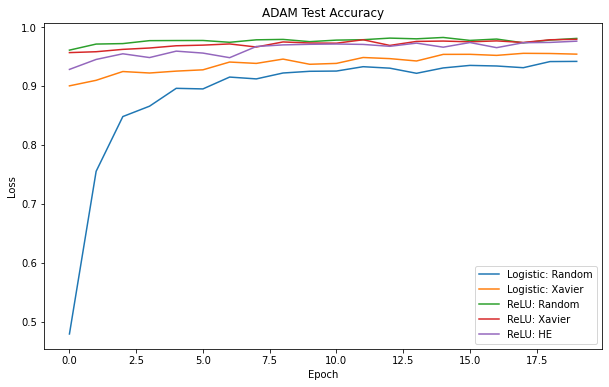

In [ ]:
fig = plt.figure(figsize = (10, 6))
for model_, _ in adam_models:
    plt.plot(model_.history.history['val_accuracy'][:20])
    
plt.legend(['Logistic: Random', 'Logistic: Xavier', 'ReLU: Random', 'ReLU: Xavier', 'ReLU: HE'], loc='lower right')
plt.title('ADAM Test Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

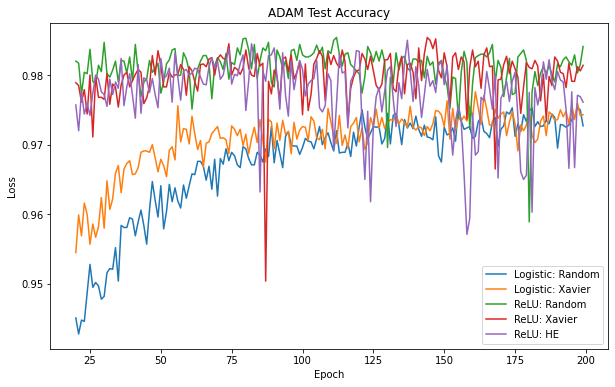

In [ ]:
fig = plt.figure(figsize = (10, 6))
for model_, _ in adam_models:
    plt.plot(range(20, 200), model_.history.history['val_accuracy'][20:])
    
plt.legend(['Logistic: Random', 'Logistic: Xavier', 'ReLU: Random', 'ReLU: Xavier', 'ReLU: HE'], loc='lower right')
plt.title('ADAM Test Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Studing the effect of Dropout

Defining the model for the 3rd question and supporting functionality.

While experimenting with what leanring rate to choose in order to replicate the graph, the following learning rates were found to be the best:-
- Learning rate = 0.01 (Default) for/with sigmoid activation function with/out dropout
- Learning rate = 0.0001 for/with Relu activation function with/out dropout

In [ ]:
model_sigmoid_xavier_no_dropout = Model(layers_nodes = [1024]*5, 
                                        activation_fn = 'sigmoid',
                                        dropout_include = False, 
                                        initializer = 'glorot_normal',
                                        include_normalization = False,
                                        optimizer = tf.keras.optimizers.Adam())

model_sigmoid_xavier_dropout = Model(layers_nodes = [1024]*5, 
                                    activation_fn = 'sigmoid',
                                    dropout_include = True, 
                                    dropout_ratio = [0.2, 0.5, 0.5, 0.5, 0.5],
                                    initializer = 'glorot_normal',
                                    include_normalization = False,
                                    optimizer = tf.keras.optimizers.Adam())

model_relu_he_no_dropout = Model(layers_nodes = [1024]*5, 
                                 activation_fn = 'relu',
                                 dropout_include = False, 
                                 initializer = 'he_normal',
                                 include_normalization = False,
                                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001))

model_relu_he_dropout = Model(layers_nodes = [1024]*5, 
                              activation_fn = 'relu',
                              dropout_include = True, 
                              dropout_ratio = [0.2, 0.5, 0.5, 0.5, 0.5],
                              initializer = 'he_normal',
                              include_normalization = False,
                              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001))


checkpoint1 = keras.callbacks.ModelCheckpoint('content/drive/DLS/Q3_sig_xav_nodrop.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
checkpoint2 = keras.callbacks.ModelCheckpoint('content/drive/DLS/Q3_sig_xav_drop.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
checkpoint3 = keras.callbacks.ModelCheckpoint('content/drive/DLS/Q3_relu_he_nodrop.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
checkpoint4 = keras.callbacks.ModelCheckpoint('content/drive/DLS/Q3_relu_he_drop.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)

sig_xav_nodrop_csv_logger = CSVLogger('content/drive/DLS/Q3_sig_xav_nodrop.log', separator=',', append=False)
sig_xav_drop_csv_logger = CSVLogger('content/drive/DLS/Q3_sig_xav_drop.log', separator=',', append=False)
relu_he_nodrop_csv_logger = CSVLogger('content/drive/DLS/Q3_relu_he_nodrop.log', separator=',', append=False)
relu_he_drop_csv_logger = CSVLogger('content/drive/DLS/Q3_relu_he_drop.log', separator=',', append=False)

    
logistic_ = [(model_sigmoid_xavier_no_dropout, checkpoint1, sig_xav_nodrop_csv_logger),
            (model_sigmoid_xavier_dropout, checkpoint2, sig_xav_drop_csv_logger)]
relu_ = [(model_relu_he_no_dropout, checkpoint3, relu_he_nodrop_csv_logger),
        (model_relu_he_dropout, checkpoint4, relu_he_drop_csv_logger)]

logistic = [model_sigmoid_xavier_no_dropout, model_sigmoid_xavier_dropout]
relu = [model_relu_he_no_dropout, model_relu_he_dropout]

In [ ]:
model_sigmoid_xavier_dropout.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
Dense_Layer_2 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 1024)              104960

### Sigmoid model training

Training for the models with Sigmoid activation function - with/o dropout.

In [ ]:
print("Training Models with Sigmoid activation functions")
for model_ in logistic:
    model_.fit(ds_train, 
                validation_data = ds_test,
                epochs = EPOCHS,
                verbose = 1,)

Training Models with Sigmoid activation functions
Epoch 1/200
469/469 [==============================] - 9s 5ms/step - loss: 1.0243 - accuracy: 0.6269 - val_loss: 0.3190 - val_accuracy: 0.9045
Epoch 2/200
469/469 [==============================] - 2s 3ms/step - loss: 0.2527 - accuracy: 0.9260 - val_loss: 0.2125 - val_accuracy: 0.9345
Epoch 3/200
469/469 [==============================] - 2s 3ms/step - loss: 0.1622 - accuracy: 0.9523 - val_loss: 0.1631 - val_accuracy: 0.9529
Epoch 4/200
469/469 [==============================] - 2s 3ms/step - loss: 0.1239 - accuracy: 0.9633 - val_loss: 0.1386 - val_accuracy: 0.9588
Epoch 5/200
469/469 [==============================] - 2s 3ms/step - loss: 0.0998 - accuracy: 0.9691 - val_loss: 0.1227 - val_accuracy: 0.9634
Epoch 6/200
469/469 [==============================] - 2s 3ms/step - loss: 0.0801 - accuracy: 0.9758 - val_loss: 0.0925 - val_accuracy: 0.9710
Epoch 7/200
469/469 [==============================] - 2s 3ms/step - loss: 0.0688 - accuracy

In [ ]:
model_relu_he_dropout.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
Dense_Layer_1 (Dense)        (None, 1024)              803840    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
Dense_Layer_2 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
Dense_Layer_3 (Dense)        (None, 1024)              1049

### ReLU model training

Training for the models with relu activation function - with/o dropout.

In [ ]:
print("Training Models with RELU activation functions")
for model_ in relu:
    model_.fit(ds_train, 
                validation_data = ds_test,
                epochs = EPOCHS,
                verbose = 1,)

Training Models with RELU activation functions
Epoch 1/200
469/469 [==============================] - 2s 3ms/step - loss: 0.2663 - accuracy: 0.9235 - val_loss: 0.1189 - val_accuracy: 0.9617
Epoch 2/200
469/469 [==============================] - 2s 3ms/step - loss: 0.0879 - accuracy: 0.9731 - val_loss: 0.0878 - val_accuracy: 0.9735
Epoch 3/200
469/469 [==============================] - 2s 3ms/step - loss: 0.0519 - accuracy: 0.9840 - val_loss: 0.0963 - val_accuracy: 0.9714
Epoch 4/200
469/469 [==============================] - 2s 3ms/step - loss: 0.0347 - accuracy: 0.9894 - val_loss: 0.0749 - val_accuracy: 0.9767
Epoch 5/200
469/469 [==============================] - 2s 3ms/step - loss: 0.0200 - accuracy: 0.9939 - val_loss: 0.0714 - val_accuracy: 0.9792
Epoch 6/200
469/469 [==============================] - 2s 3ms/step - loss: 0.0148 - accuracy: 0.9952 - val_loss: 0.0709 - val_accuracy: 0.9799
Epoch 7/200
469/469 [==============================] - 2s 3ms/step - loss: 0.0107 - accuracy: 0

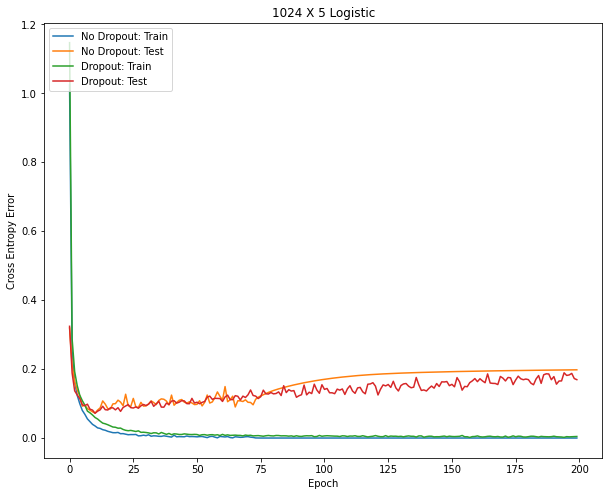

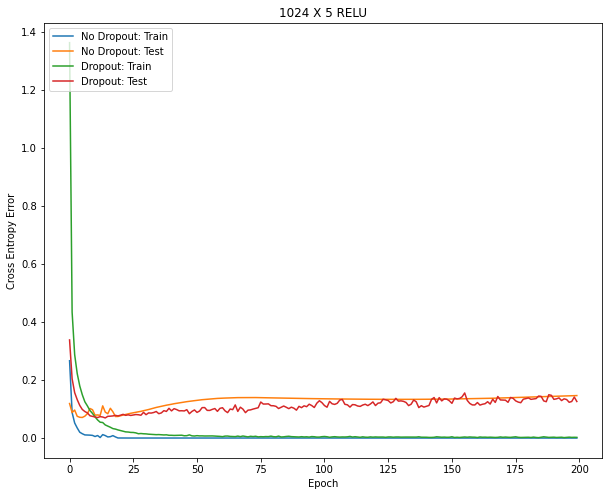

In [ ]:
fig = plt.figure(figsize = (10, 8))

for model_ in logistic:
    plt.plot(model_.history.history['loss'])
    plt.plot(model_.history.history['val_loss'])
    
plt.legend(['No Dropout: Train', 'No Dropout: Test', 'Dropout: Train', 'Dropout: Test'], loc='upper left')
plt.title('1024 X 5 Logistic')
plt.ylabel('Cross Entropy Error')
plt.xlabel('Epoch')
plt.show()

fig = plt.figure(figsize = (10, 8))
for model_ in relu:
    plt.plot(model_.history.history['loss'])
    plt.plot(model_.history.history['val_loss'])
    
plt.legend(['No Dropout: Train', 'No Dropout: Test', 'Dropout: Train', 'Dropout: Test'], loc='upper left')
plt.title('1024 X 5 RELU')
plt.ylabel('Cross Entropy Error')
plt.xlabel('Epoch')
plt.show()

#### Bonus part:
did the below training in order to compare the effect of normalization on th model with the non-normalized input.

As it becomes evident from the below graph plotting that a graph converges fast as compared to a non-normalized input.

In [ ]:
model_sigmoid_xavier_no_dropout2 = Model(layers_nodes = [1024]*5, 
                                        activation_fn = 'sigmoid',
                                        dropout_include = False, 
                                        initializer = 'glorot_normal',
                                        include_normalization = True)

model_sigmoid_xavier_dropout2 = Model(layers_nodes = [1024]*5, 
                                    activation_fn = 'sigmoid',
                                    dropout_include = True, 
                                    dropout_ratio = [0.2, 0.5, 0.5, 0.5, 0.5],
                                    initializer = 'glorot_normal',
                                    include_normalization = True)

model_relu_he_no_dropout2 = Model(layers_nodes = [1024]*5, 
                                 activation_fn = 'relu',
                                 dropout_include = False, 
                                 initializer = 'he_normal',
                                 include_normalization = True)

model_relu_he_dropout2 = Model(layers_nodes = [1024]*5, 
                              activation_fn = 'relu',
                              dropout_include = True, 
                              dropout_ratio = [0.2, 0.5, 0.5, 0.5, 0.5],
                              initializer = 'he_normal',
                              include_normalization = True)

logistic2 = [model_sigmoid_xavier_no_dropout2, model_sigmoid_xavier_dropout2]
relu2 = [model_relu_he_no_dropout2, model_relu_he_dropout2]

for model_ in logistic2:
    model_.fit(ds_train, 
                validation_data = ds_test,
                epochs = EPOCHS,
                verbose = 1,)
    
for model_ in relu2:

    model_.fit(ds_train, 
                validation_data = ds_test,
                epochs = EPOCHS,
                verbose = 1,)

Epoch 1/200
469/469 [==============================] - 19s 16ms/step - loss: 0.3927 - accuracy: 0.8925 - val_loss: 0.4119 - val_accuracy: 0.8736
Epoch 2/200
469/469 [==============================] - 6s 13ms/step - loss: 0.2697 - accuracy: 0.9188 - val_loss: 0.4165 - val_accuracy: 0.8703
Epoch 3/200
469/469 [==============================] - 6s 12ms/step - loss: 0.2411 - accuracy: 0.9242 - val_loss: 0.2487 - val_accuracy: 0.9280
Epoch 4/200
469/469 [==============================] - 6s 12ms/step - loss: 0.2245 - accuracy: 0.9315 - val_loss: 0.2694 - val_accuracy: 0.9171
Epoch 5/200
469/469 [==============================] - 6s 12ms/step - loss: 0.2105 - accuracy: 0.9353 - val_loss: 0.2377 - val_accuracy: 0.9258
Epoch 6/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1880 - accuracy: 0.9417 - val_loss: 0.1739 - val_accuracy: 0.9465
Epoch 7/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1808 - accuracy: 0.9427 - val_loss: 0.2934 - val_accuracy

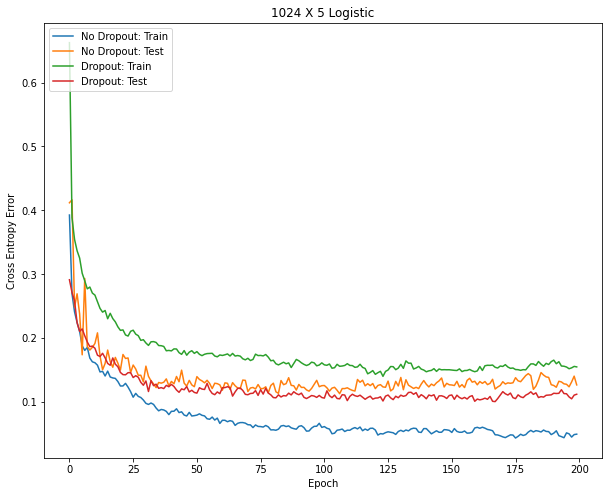

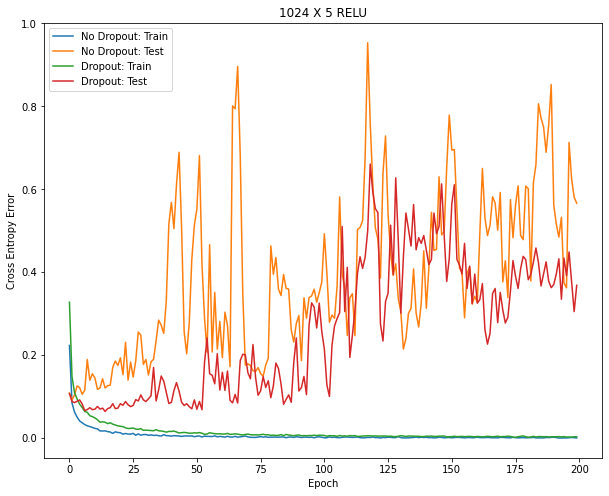

In [ ]:
fig = plt.figure(figsize = (10, 8))

for model_ in logistic2:
    plt.plot(model_.history.history['loss'])
    plt.plot(model_.history.history['val_loss'])
    
plt.legend(['No Dropout: Train', 'No Dropout: Test', 'Dropout: Train', 'Dropout: Test'], loc='upper left')
plt.title('1024 X 5 Logistic')
plt.ylabel('Cross Entropy Error')
plt.xlabel('Epoch')
plt.show()

fig = plt.figure(figsize = (10, 8))
for model_ in relu2:
    plt.plot(model_.history.history['loss'])
    plt.plot(model_.history.history['val_loss'])
    
plt.legend(['No Dropout: Train', 'No Dropout: Test', 'Dropout: Train', 'Dropout: Test'], loc='upper left')
plt.title('1024 X 5 RELU')
plt.ylabel('Cross Entropy Error')
plt.xlabel('Epoch')
plt.show()